In [1]:
from google.colab import drive
drive.mount('/content/drive')
!ls "/content/drive/My Drive/Colab Notebooks"
%cd drive/MyDrive/Colab\ Notebooks

Mounted at /content/drive
a	    efficientnet.ipynb	    landmark_retrieval.ipynb  resnet.ipynb
caltech256  genre.ipynb		    learning.txt	      result_jpg_300
delf.ipynb  image_captioning.ipynb  mbart_translation.ipynb
/content/drive/MyDrive/Colab Notebooks


In [2]:
!pip install faiss-cpu --no-cache

     |████████████████████████████████| 8.4 MB 26.9 MB/s 


In [3]:
import torch
import torchvision
import numpy as np
import cv2 as cv

import matplotlib.pyplot as plt
import os
import faiss

from pathlib import Path
from collections import defaultdict

In [4]:
# Choose ResNet 101 model with ImageNet pretrained weights
model = torchvision.models.resnet101(pretrained=True)
model.eval()

Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [5]:
# # for Imat2011 dataset:
# image_group = 10
# path_tmpl = 'result_jpg_300/' + '%d_%d.jpg'
# paths = [path_tmpl % (image_group, i) for i in range(1,6)]
# imgs = [cv.imread(path) for path in paths]

# for Caltech256 dataset:
imgs = []
categories = []
for root, _, _ in os.walk("caltech256/"):
    category = root[12:14]
    if root != "caltech256/":
        for filename in os.listdir(root):
          img = cv.imread(os.path.join(root, filename))
          imgs.append(img)
          categories.append(category)

In [ ]:
imgs = [cv.resize(img, (224, 224), interpolation = cv.INTER_AREA) for img in imgs]

In [6]:
# # for Imat2011 dataset:
# # path_labels = PATH_PROJECT / '.data/imat2011/learning.txt'
# path_labels = 'learning.txt'

# def get_labels(path_lables):
    
#     with open(path_lables, 'r', newline='\n') as fin:
#         learning = [line.strip() for line in fin]
    
#     learning_dict = defaultdict(set)
#     for l in learning:
#         g, i = l.split('.')[0].split('_')
#         learning_dict[int(g)].add(int(i))
    
#     return learning_dict

# learning_dict = get_labels(path_labels)

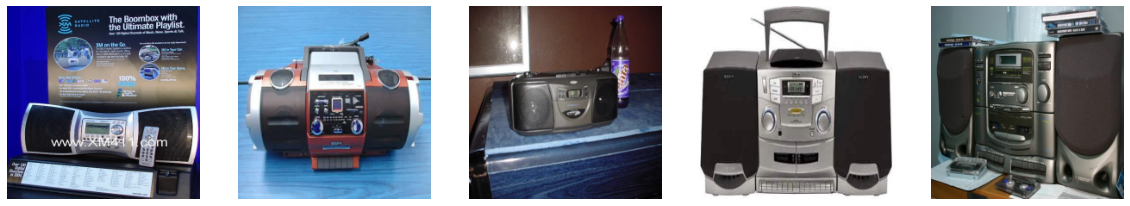

In [7]:
plt.figure(figsize=(20, 10))
# for i, img in enumerate(imgs, 1):
for i, img in enumerate(imgs[:5], 1):
    ax = plt.subplot(1, 5, i)
    plt.imshow(img)
    # if i in learning_dict[image_group]:
    #     plt.title("SET %d" % i)
    # else:
    #     plt.title("%d" % i)
    plt.axis("off")

In [8]:
# # for Imat2011 dataset:
# imgs = []
# root = "result_jpg_300/"
# for filename in os.listdir(root):
#     img = cv.imread(os.path.join(root,filename))
#     img = cv.resize(img, (224, 224), interpolation = cv.INTER_AREA)
#     imgs.append(img)

In [ ]:
imgs = np.array(imgs)

In [9]:
# Get image embeddings
embeddings = []
preprocess = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = [preprocess(img) for img in imgs]
for img in input_tensor:
    input_batch = img.unsqueeze(0) # create a mini-batch as expected by the model

    # move the input and model to GPU for speed if available
    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        model.to('cuda')

    with torch.no_grad():
        output = model(input_batch)
    # Tensor of shape 1000, with confidence scores over Imagenet's 1000 classes
    embeddings.append(output.cpu().numpy())

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [10]:
embeddings = np.array(embeddings)
embeddings = embeddings.reshape((-1, 1000))

In [11]:
# Search similar embeddings by Faiss
index = faiss.IndexFlatL2(1000)
index.add(embeddings)

In [52]:
k = 10
image_idx = 1400 # Set index of query image
D, I = index.search(embeddings[image_idx].reshape((1, 1000)), k)

In [53]:
# Show indexes and distances
I, D

(array([[1400, 1349, 1317, 1322, 1372, 1365, 1307, 1368, 1371, 1652]]),
 array([[   0.    , 1988.7648, 2512.403 , 3152.3003, 3351.9165, 3727.1462,
         3739.6208, 3750.2432, 3803.5344, 3988.1833]], dtype=float32))

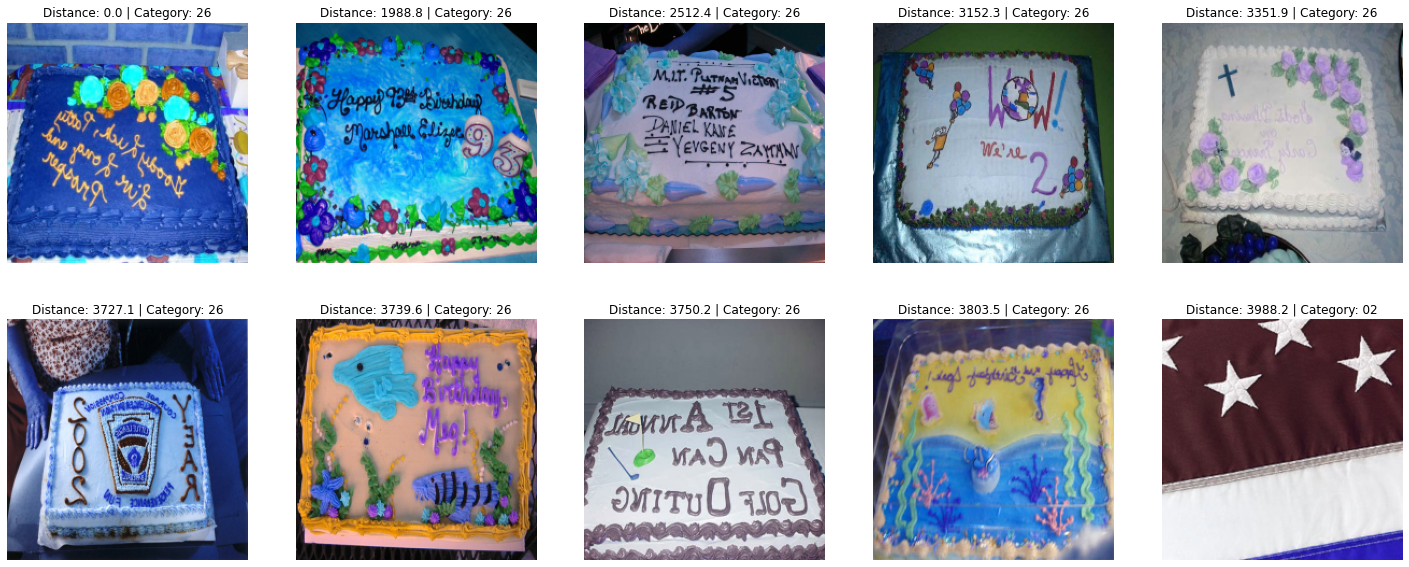

In [54]:
plt.figure(figsize=(25, 10))
for i, idx in enumerate(I[0], 1):
    ax = plt.subplot(2, 5, i)
    plt.imshow(imgs[idx])
    plt.title("Distance: " + str(round(D[0][i - 1], 1)) + " | Category: " + str(categories[idx]))
    plt.axis("off")